# Prompt controlled bject segmentations with FastSAM and OpenVINO
The Fast Segment Anything Model (FastSAM) is a real-time CNN-based model that can segment any object within an image based on various user prompts. `Segment Anything` task is designed to make vision tasks easier by providing an efficient way to identify objects in an image. FastSAM significantly reduces computational demands while maintaining competitive performance, making it a practical choice for a variety of vision tasks.

FastSAM is a model that aims to overcome the limitations of the Segment Anything Model (SAM), which is a Transformer model that requires significant computational resources. FastSAM tackles the segment anything task by dividing it into two consecutive stages: all-instance segmentation and prompt-guided selection. 

In the first stage, YOLOv8-seg is used to produce segmentation masks for all instances in the image. In the second stage, FastSAM outputs the region-of-interest corresponding to the prompt.

![pipeline](https://user-images.githubusercontent.com/26833433/248551984-d98f0f6d-7535-45d0-b380-2e1440b52ad7.jpg)

Contents:
- [Requirements and Imports](#Prerequisites)
- [Original Pipeline Inference](#FastSAM-in-Ultralytics)
- [Converting the Model to OpenVINO IR](#Convert-the-model-to-OpenVINO-Intermediate-representation-(IR)-format)
- [Embedding the Converted Models into the Pipeline](#Embedding-the-converted-models-into-the-original-pipeline)
- [Run Gradio App](#Try-out-the-converted-pipeline)

## Prerequisites

### Install requirements

In [1]:
%pip install -q ultralytics onnx
%pip install -q "openvino-dev>=2023.1.0"
%pip install -q gradio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Imports

In [2]:
from pathlib import Path

import openvino as ov
import torch
from PIL import Image, ImageDraw
from ultralytics import FastSAM
from ultralytics.models.fastsam import FastSAMPrompt

## FastSAM in Ultralytics

To work with [Fast Segment Anything Model](https://github.com/CASIA-IVA-Lab/FastSAM) by CASIA-IVA-Lab, we will use the [Ultralytics package](https://docs.ultralytics.com/). Ultralytics package exposes the `FastSAM` class, simplifying the model instantiation and weights loading. The code below demonstrates how to initialize a `FastSAM` model and generate a segmentation map.

In [3]:
device = 'cpu'

model_name = 'FastSAM-x'
model = FastSAM(model_name)

# Run inference on an image
image_uri = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg'
results = model(image_uri, device=device, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9)

100%|██████████| 138M/138M [00:05<00:00, 28.8MB/s] 

100%|██████████| 182k/182k [00:00<00:00, 721kB/s] 
image 1/1 /home/idavidyu/openvino_notebooks/notebooks/257-fast-segment-anything/coco_bike.jpg: 768x1024 61 objects, 613.0ms
Speed: 3.3ms preprocess, 613.0ms inference, 42.0ms postprocess per image at shape (1, 3, 768, 1024)


The model returns segmentation maps for all the objects on the image. Observe the result visulisation below.

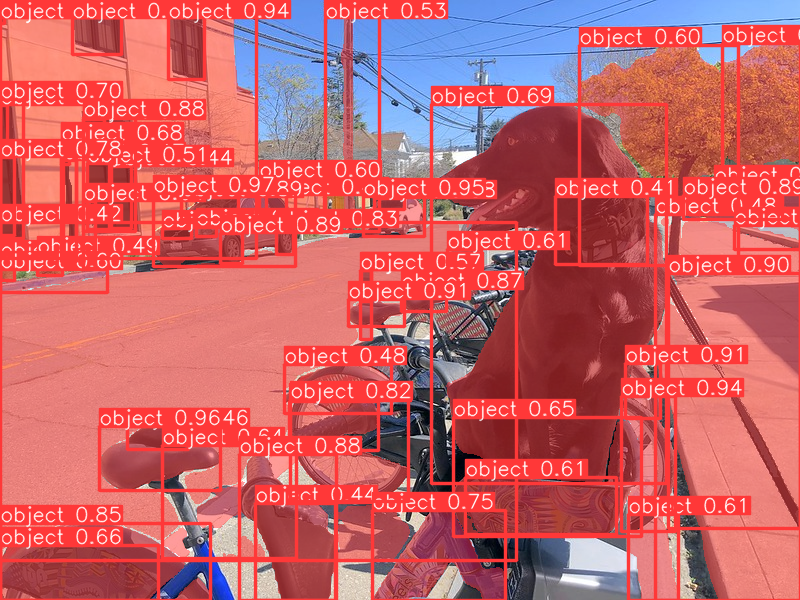

In [4]:
Image.fromarray(results[0].plot()[..., ::-1])

## Convert the model to OpenVINO Intermediate representation (IR) format
The Ultralytics Model export API enables conversion of PyTorch models to OPenVINO IR format. Under the hood it utilizes the `openvino.convert_model` method to acquire OpenVINO IR versions of the models. The method requires a model object and example input for model tracing. The FastSAM model itself is based on YOLOv8 model.

In [5]:
# instance segmentation model
ov_model_path = Path(f'{model_name}_openvino_model/{model_name}.xml')
if not ov_model_path.exists():
    ov_model = model.export(format="openvino", dynamic=True, half=False)


Ultralytics YOLOv8.0.199 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Core(TM) i9-10980XE 3.00GHz)

PyTorch: starting from 'FastSAM-x.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) ((1, 37, 21504), (1, 32, 256, 256)) (138.2 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success ✅ 5.6s, saved as 'FastSAM-x.onnx' (275.5 MB)

OpenVINO: starting export with openvino 2023.1.0-12185-9e6b00e51cd-releases/2023/1...
OpenVINO: export success ✅ 1.1s, saved as 'FastSAM-x_openvino_model/' (275.9 MB)

Export complete (9.5s)
Results saved to /home/idavidyu/openvino_notebooks/notebooks/257-fast-segment-anything
Predict:         yolo predict task=segment model=FastSAM-x_openvino_model imgsz=1024  
Validate:        yolo val task=segment model=FastSAM-x_openvino_model imgsz=1024 data=ultralytics/datasets/sa.yaml  
Visualize:       https://netron.app


## Embedding the converted models into the original pipeline

OpenVINO™ Runtime Python API is used to compile the model in OpenVINO IR format. The [Core](https://docs.openvino.ai/2022.3/api/ie_python_api/_autosummary/openvino.runtime.Core.html) class provides access to the OpenVINO Runtime API. The `core` object, which is an instance of the `Core` class represents the API and it is used to compile the model.

In [6]:
core = ov.Core()

#### Select inference device

Select device that will be used to do models inference using OpenVINO from the dropdown list:

In [7]:
import ipywidgets as widgets

DEVICE = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

DEVICE

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### Adapt OpenVINO models to the original pipeline

Here we create wrapper classes for the OpenVINO model that we want to embed in the original inference pipeline.
Here are some of the things to consider when adapting an OV model:
 - Make sure that parameters passed by the original pipeline are forwarded to the compiled OV model properly; sometimes the OV model uses only a portion of the input arguments and some are ignored, sometimes you need to convert the argument to another data type or unwrap some data structures such as tuples or dictionaries.
 - Guarantee that the wrapper class returns results to the pipeline in an expected format. In the example below you can see how we pack OV model outputs into a tuple of `torch` tensors.
 - Pay attention to the model method used in the original pipeline for calling the model - it may be not the `forward` method! In this example, the model is a part of a `predictor` object and called as and object, so we need to redefine the magic `__call__` method.

In [8]:
class OVWrapper(torch.nn.Module):
    def __init__(self, ov_model, device="CPU", stride=32) -> None:
        super().__init__()
        self.model = ov.compile_model(ov_model)

        self.stride = stride
        self.pt = True
        self.fp16 = False
        self.names = {0: 'object'}

    def __call__(self, im, **_):
        result = self.model(im)
        return (torch.tensor(result[0]), torch.tensor(result[1]))

Now we initialize the wrapper objects and load them to the FastSAM pipeline.

In [9]:
wrapped_model = OVWrapper(ov_model_path, device=DEVICE.value, stride=model.predictor.model.stride)
model.predictor.model = wrapped_model

ov_results = model(image_uri, device=device, retina_masks=True, imgsz=640, conf=0.4, iou=0.9)


Found https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg locally at coco_bike.jpg
image 1/1 /home/idavidyu/openvino_notebooks/notebooks/257-fast-segment-anything/coco_bike.jpg: 480x640 51 objects, 353.5ms
Speed: 2.9ms preprocess, 353.5ms inference, 43.2ms postprocess per image at shape (1, 3, 480, 640)


One can observe the converted model outputs in the next cell, they is the same as of the original model.

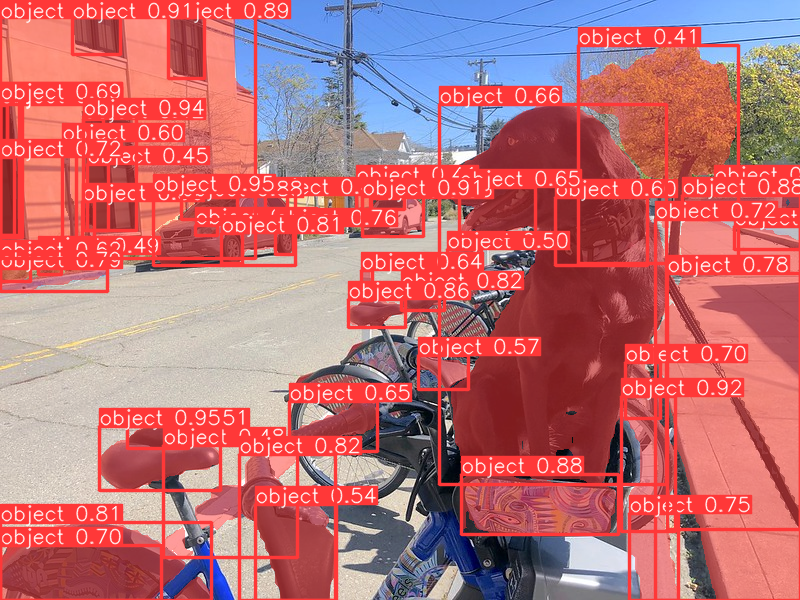

In [10]:
Image.fromarray(ov_results[0].plot()[..., ::-1])

## Try out the converted pipeline

The demo app below is created using [Gradio package](https://www.gradio.app/docs/interface)

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fast_process(
    annotations,
    image,
    scale,
    better_quality=False,
    mask_random_color=True,
    bbox=None,
    use_retina=True,
    withContours=True,
):

    original_h = image.height
    original_w = image.width

    if better_quality:
        for i, mask in enumerate(annotations):
            mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
            annotations[i] = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((8, 8), np.uint8))
    # device is CPU

    inner_mask = fast_show_mask(
        annotations,
        plt.gca(),
        random_color=mask_random_color,
        bbox=bbox,
        retinamask=use_retina,
        target_height=original_h,
        target_width=original_w,
    )

    if withContours:
        contour_all = []
        temp = np.zeros((original_h, original_w, 1))
        for i, mask in enumerate(annotations):
            if type(mask) == dict:
                mask = mask['segmentation']
            annotation = mask.astype(np.uint8)
            if use_retina == False:
                annotation = cv2.resize(
                    annotation,
                    (original_w, original_h),
                    interpolation=cv2.INTER_NEAREST,
                )
            contours, _ = cv2.findContours(annotation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                contour_all.append(contour)
        cv2.drawContours(temp, contour_all, -1, (255, 255, 255), 2 // scale)
        color = np.array([0 / 255, 0 / 255, 255 / 255, 0.9])
        contour_mask = temp / 255 * color.reshape(1, 1, -1)

    image = image.convert('RGBA')
    overlay_inner = Image.fromarray((inner_mask * 255).astype(np.uint8), 'RGBA')
    image.paste(overlay_inner, (0, 0), overlay_inner)

    if withContours:
        overlay_contour = Image.fromarray((contour_mask * 255).astype(np.uint8), 'RGBA')
        image.paste(overlay_contour, (0, 0), overlay_contour)

    return image


# CPU post process
def fast_show_mask(
    annotation,
    ax,
    random_color=False,
    bbox=None,
    retinamask=True,
    target_height=960,
    target_width=960,
):
    mask_sum = annotation.shape[0]
    height = annotation.shape[1]
    weight = annotation.shape[2]
    # 
    areas = np.sum(annotation, axis=(1, 2))
    sorted_indices = np.argsort(areas)[::1]
    annotation = annotation[sorted_indices]

    index = (annotation != 0).argmax(axis=0)
    if random_color:
        color = np.random.random((mask_sum, 1, 1, 3))
    else:
        color = np.ones((mask_sum, 1, 1, 3)) * np.array([30 / 255, 144 / 255, 255 / 255])
    transparency = np.ones((mask_sum, 1, 1, 1)) * 0.6
    visual = np.concatenate([color, transparency], axis=-1)
    mask_image = np.expand_dims(annotation, -1) * visual

    mask = np.zeros((height, weight, 4))

    h_indices, w_indices = np.meshgrid(np.arange(height), np.arange(weight), indexing='ij')
    indices = (index[h_indices, w_indices], h_indices, w_indices, slice(None))

    mask[h_indices, w_indices, :] = mask_image[indices]
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='b', linewidth=1))

    if not retinamask:
        mask = cv2.resize(mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

    return mask

In [12]:
import gradio as gr

device = 'cpu'

examples = [[image_uri], ['https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/empty_road_mapillary.jpg'],
            ['https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/wall.jpg']]

object_points = []
background_points = []
bbox_points = []
last_image = examples[0][0]

This is the main callback function that is called to segment an image based on user input.

In [13]:
def segment(image,
    input_size=1024, 
    iou_threshold=0.7,
    conf_threshold=0.25,
    better_quality=True,
    withContours=True,
    use_retina=True,
    wider=False,
    mask_random_color=True,
):
    input_size = int(input_size)
    w, h = image.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))

    results = model(image,
                    device='cpu',
                    retina_masks=use_retina,
                    iou=iou_threshold,
                    conf=conf_threshold,
                    imgsz=input_size,)

    masks = results[0].masks.data
    # Calculate annotations
    if not (object_points or bbox_points):
        annotations = masks.cpu().numpy()
    else:
        annotations = []

    if object_points:
        all_points = object_points + background_points
        labels = [1] * len(object_points) + [0] * len(background_points)
        scaled_points = [[int(x * scale) for x in point] for point in all_points]
        h, w = masks[0].shape[:2]
        assert max(h, w) == input_size
        onemask = np.zeros((h, w))
        for mask in sorted(masks, key=lambda x: x.sum(), reverse=True):
            mask_np = (mask == 1.0).cpu().numpy()
            for point, label in zip(scaled_points, labels):
                if mask_np[point[1], point[0]] == 1 and label == 1:
                    onemask[mask_np] = 1
                if mask_np[point[1], point[0]] == 1 and label == 0:
                    onemask[mask_np] = 0
        annotations.append(onemask >= 1)
    if len(bbox_points) >= 2:
        scaled_bbox_points = []
        for i, point in enumerate(bbox_points):
            x, y = int(point[0] * scale), int(point[1] * scale)
            x = max(min(x, new_w), 0)
            y = max(min(y, new_h), 0)
            scaled_bbox_points.append((x, y))

        for i in range(0, len(scaled_bbox_points) - 1, 2):
            x0, y0, x1, y1 = *scaled_bbox_points[i], *scaled_bbox_points[i + 1]
            
            intersection_area = torch.sum(masks[:, y0:y1, x0:x1], dim=(1, 2))
            masks_area = torch.sum(masks, dim=(1, 2))
            bbox_area = (y1 - y0) * (x1 - x0)

            union = bbox_area + masks_area - intersection_area
            iou = intersection_area / union
            max_iou_index = torch.argmax(iou)

            annotations.append(masks[max_iou_index].cpu().numpy())

    return fast_process(annotations=np.array(annotations),
                       image=image,
                       scale=(1024 // input_size),
                       better_quality=better_quality,
                       mask_random_color=mask_random_color,
                       bbox=None,
                       use_retina=use_retina,
                       withContours=withContours,)

In [14]:
def select_point(img: Image.Image, point_type: str, evt: gr.SelectData) -> Image.Image:
    """Gradio select callback."""
    img = img.convert("RGBA")
    x, y = evt.index[0], evt.index[1]
    point_radius = np.round(max(img.size) / 100)
    if point_type == 'Object point':
        object_points.append((x, y))
        color = (30, 255, 30, 200)
    elif point_type == 'Background point':
        background_points.append((x, y))
        color = (255, 30, 30, 200)
    elif point_type == 'Bounding Box':
        bbox_points.append((x, y))
        color = (10, 10, 255, 255)
        if len(bbox_points) % 2 == 0:
            # Draw a rectangle if number of points is even
            new_img = Image.new('RGBA', img.size, (255, 255, 255, 0))
            _draw = ImageDraw.Draw(new_img)
            x0, y0, x1, y1 = *bbox_points[-2], *bbox_points[-1]
            x0, x1 = sorted([x0, x1])
            y0, y1 = sorted([y0, y1])
            # Save sorted order
            bbox_points[-2] = (x0, y0)
            bbox_points[-1] = (x1, y1)
            _draw.rectangle((x0, y0, x1, y1), fill=(*color[:-1], 90))
            img = Image.alpha_composite(img, new_img)
    # Draw a point
    ImageDraw.Draw(img).ellipse(
        [(x - point_radius, y - point_radius), (x + point_radius, y + point_radius)],
        fill=color
    )
    return img

def clear_points() -> (Image.Image, None):
    """Gradio clear points callback."""
    global object_points, background_points, bbox_points
    # global object_points; global background_points; global bbox_points
    object_points = []
    background_points = []
    bbox_points = []
    return last_image, None

def save_last_picked_image(img: Image.Image) -> None:
    """Gradio callback saves the last used image."""
    global last_image
    last_image = img
    # If we change the input image
    # we should clear all the previous points
    clear_points()
    # Removes the segmentation map output
    return None

with gr.Blocks(title='Fast SAM') as demo:
    with gr.Row(variant="panel"):
        original_img = gr.Image(label="Input", value=examples[0][0], type='pil')
        segmented_img = gr.Image(label="Segmentation Map", type='pil')
    point_type = gr.Radio(['Object point', 'Background point', 'Bounding Box'],
             value='Object point', label='Pixel selector type')
    with gr.Row(variant="panel"):
        segment_button = gr.Button("Segment", variant='primary')
        clear_button = gr.Button("Clear points", variant='secondary')
    gr.Examples(examples, inputs=original_img,
                fn=save_last_picked_image, run_on_click=True, outputs=segmented_img
   )

    # Callbacks
    original_img.select(select_point,
                        inputs=[original_img, point_type],
                        outputs=original_img)
    original_img.upload(save_last_picked_image, inputs=original_img, outputs=segmented_img)
    clear_button.click(clear_points, outputs=[original_img, segmented_img])
    segment_button.click(segment, inputs=[original_img,], outputs=segmented_img)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)

# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name='your server name', server_port='server port in int')`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.



0: 768x1024 101 objects, 2944.1ms
Speed: 5.7ms preprocess, 2944.1ms inference, 657.4ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 102 objects, 2944.6ms
Speed: 3.9ms preprocess, 2944.6ms inference, 560.0ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 104 objects, 4406.7ms
Speed: 10.2ms preprocess, 4406.7ms inference, 611.8ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 105 objects, 2642.5ms
Speed: 3.7ms preprocess, 2642.5ms inference, 566.2ms postprocess per image at shape (1, 3, 768, 1024)

0: 768x1024 101 objects, 3446.9ms
Speed: 5.3ms preprocess, 3446.9ms inference, 693.7ms postprocess per image at shape (1, 3, 768, 1024)


Keyboard interruption in main thread... closing server.
